### 📓 `21_predictive_regime_transition_modeling_catboost.ipynb`

## 🔍 Purpose

This notebook implements a supervised learning pipeline to **predict the next market regime** (`Cluster_ID[t + 1]`) based on:

* Lagged regime states (e.g., `Cluster_ID[t - 1]`, `t - 2`, ...)
* Market features used in the original transformer embedding (e.g., `LC_Slope`, `ATR`, `AHMA`, etc.)

It augments the unsupervised clustering approach in `regimetry` by introducing **predictive intelligence** for:

* Early warnings of regime transitions
* SHAP-based explanation of transition causes
* Drift detection (when predicted ≠ actual transitions)
* Benchmarking against the Markov transition matrix

---

## 🧱 Build Plan

### Step 1. Load and Inspect Data

* Load cluster-labeled time series with technical features
* Ensure time ordering is preserved

### Step 2. Create Lagged Regime Features

* Add `Cluster_ID_Lag_1`, `_Lag_2`, ..., `_Lag_n`
* Define target as `Cluster_ID[t + 1]`

### Step 3. Define Feature Set and Target

* Combine lagged labels + technical indicators as predictors
* Filter for valid (non-null) rows

### Step 4. Time-Based Train/Test Split

* Use 80/20 chronological split (no shuffling)

### Step 5. Train `CatBoostClassifier`

* With early stopping on validation loss

### Step 6. Evaluate Accuracy

* Predict `Cluster_ID[t + 1]` on test set
* Report accuracy

### Step 7. Visualize SHAP Values

* Explain which features contributed to each predicted regime

### Step 8. Drift Detection

* Compare predicted vs. actual cluster transitions
* Visualize rolling drift rate

### Step 9. Benchmark: Markov vs. Predictive

* Compare CatBoost prediction accuracy to static Markov matrix

---

Let me know when you'd like to insert this into the notebook or move on to Step 2.


In [1]:
import pandas as pd
import os
from os import path

import numpy as np

import shap

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import entropy
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

from catboost import CatBoostClassifier,Pool

from regimetry.config import Config
from regimetry.logger_manager import LoggerManager
from regimetry.services.data_transformation_service import DataTransformationService

/Users/kenneth/Public/projects/python/ai/regimetry/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
logging = LoggerManager.get_logger("predictive_regime_transistion_analysis")

In [3]:
cfg = Config()
print("PROJECT ROOT:", cfg.PROJECT_ROOT)
print("BASE DIR:", cfg.BASE_DIR)
print("RAW DATA:", cfg.RAW_DATA_DIR)
print("PROCESSED DATA:", cfg.PROCESSED_DATA_DIR)
print("EMBEDDINGS DATA:", cfg.EMBEDDINGS_DIR) 
print("REPORTS DATA:", cfg.REPORTS_DIR) 

PROJECT ROOT: /Users/kenneth/Public/projects/python/ai/regimetry
BASE DIR: /Users/kenneth/Public/projects/python/ai/regimetry/artifacts
RAW DATA: /Users/kenneth/Public/projects/python/ai/regimetry/artifacts/data/raw
PROCESSED DATA: /Users/kenneth/Public/projects/python/ai/regimetry/artifacts/data/processed
EMBEDDINGS DATA: /Users/kenneth/Public/projects/python/ai/regimetry/artifacts/embeddings
REPORTS DATA: /Users/kenneth/Public/projects/python/ai/regimetry/artifacts/reports


## 1. Load and Inspect Data

- Load cluster-labeled time series data with market features.
- Verify data integrity and maintain chronological order.


In [4]:
### ✅ Step 1: Load and Preview Cluster Data
# Load your regime-labeled CSV file
file_path = path.join(cfg.REPORTS_DIR,"EUR_USD/ws5/learnable64/default/nc10", "cluster_assignments.csv")
df = pd.read_csv(file_path)
print(f"🔢 Raw shape: {df.shape}")

# 🔍 Check for missing values
nan_summary = df.isnull().sum()
nan_cols = nan_summary[nan_summary > 0]
if not nan_cols.empty:
    print("⚠️ Columns with missing values:")
    print(nan_cols)
else:
    print("✅ No missing values detected.")

# Optionally drop all rows with any NaNs
df = df.dropna()
print(f"✅ After dropna(): {df.shape}")

# Preview the top of the dataframe
df.head()

🔢 Raw shape: (1878, 54)
⚠️ Columns with missing values:
Cluster_ID    4
dtype: int64
✅ After dropna(): (1874, 54)


,Open,High,Low,Close,Volume,Predictions,Confidence,ATR,AHMA,Leavitt_Projection,...,Momentum_Divergence_Bull,Momentum_Divergence_Bear,Classic_Divergence_Bull,Classic_Divergence_Bear,RHD_Bull,RHD_Bear,Day_Of_Week,Month,Year,Cluster_ID
4,1.23183,1.23656,1.22689,1.23358,70397,1,0.811105,0.009387,1.227637,1.221931,...,0,0,0,0,Strong,Strong,6,3,2018,6.0
5,1.23358,1.24205,1.23284,1.24050,60303,2,0.944401,0.009364,1.232025,1.225456,...,0,0,0,0,Strong,Strong,0,3,2018,6.0
6,1.24050,1.24464,1.23849,1.24114,66027,1,0.816634,0.008935,1.236044,1.230460,...,0,0,0,0,Strong,Strong,1,3,2018,8.0
7,1.24114,1.24465,1.22978,1.23122,79137,0,0.921425,0.009726,1.235998,1.234613,...,0,0,1,0,Weak,Strong,2,3,2018,8.0
8,1.23122,1.23346,1.22728,1.23059,64098,1,0.884503,0.009254,1.234609,1.237510,...,0,0,1,0,Weak,Strong,3,3,2018,8.0


## 2. Create Lagged Regime Features

- Generate lag features for previous regime states (`Cluster_ID_Lag_1`, `Cluster_ID_Lag_2`, etc.).
- Define the target variable as the next regime state (`Cluster_ID_Next`).
- Drop rows with NaNs caused by lag/lead shifting.

In [5]:
# We'll use the last 3 regime states as input features
max_lag = 3

# Generate lagged features for Cluster_ID
for lag in range(1, max_lag + 1):
    df[f"Cluster_ID_Lag_{lag}"] = df["Cluster_ID"].shift(lag)

# Define the prediction target: the next regime state
df["Cluster_ID_Next"] = df["Cluster_ID"].shift(-1)

# Drop rows that contain NaNs due to shifting (start/end of series)
required_cols = [f"Cluster_ID_Lag_{lag}" for lag in range(1, max_lag + 1)] + ["Cluster_ID_Next"]
df_model = df.dropna(subset=required_cols).copy()

# Preview the result
df_model[["Cluster_ID"] + required_cols].head()

,Cluster_ID,Cluster_ID_Lag_1,Cluster_ID_Lag_2,Cluster_ID_Lag_3,Cluster_ID_Next
7,8.0,8.0,6.0,6.0,8.0
8,8.0,8.0,8.0,6.0,8.0
9,8.0,8.0,8.0,8.0,6.0
10,6.0,8.0,8.0,8.0,6.0
11,6.0,6.0,8.0,8.0,6.0


## 3. Define Feature Set and Target

- Select lagged regime labels and technical indicators as features.
- Exclude irrelevant columns.
- Prepare categorical columns for encoding.


In [6]:
# Define feature matrix X and target vector y for model training

# Set config to include all columns by default, exclude known irrelevant ones
cfg.include_columns = "*"
cfg.exclude_columns = [
    "Date", "Open", "High", "Low", "Close", "Volume",
    "Predictions", "ML_Trade_Direction", "ML_Signal_Quality",
    "Entry_Trigger", "Entry_Confirmed",
    "Cluster_ID", "Cluster_ID_Next"
]

# Determine columns to include based on config
if cfg.include_columns == "*":
    selected_cols = df_model.columns.tolist()
else:
    selected_cols = [col for col in cfg.include_columns if col in df_model.columns]

if cfg.exclude_columns:
    selected_cols = [col for col in selected_cols if col not in cfg.exclude_columns]

# Identify lag, ordinal categorical (RHD_*), and numeric features
lag_cols = [col for col in selected_cols if col.startswith("Cluster_ID_Lag_")]
ordinal_cols = [col for col in selected_cols if col.startswith("RHD_") and df_model[col].dtype == "object"]
numeric_cols = [
    col for col in selected_cols
    if col not in lag_cols + ordinal_cols and df_model[col].dtype in ["float64", "int64"]
]

# Construct feature matrix X and target vector y
X = df_model[lag_cols + numeric_cols + ordinal_cols]
Y = df_model["Cluster_ID_Next"]

print(f"Features shape: {X.shape}, Target shape: {Y.shape}")
X.head()


Features shape: (1870, 43), Target shape: (1870,)


,Cluster_ID_Lag_1,Cluster_ID_Lag_2,Cluster_ID_Lag_3,Confidence,ATR,AHMA,Leavitt_Projection,Leavitt_Convolution,LC_Slope,LC_Intercept,...,Expansion_Bear,Momentum_Divergence_Bull,Momentum_Divergence_Bear,Classic_Divergence_Bull,Classic_Divergence_Bear,Day_Of_Week,Month,Year,RHD_Bull,RHD_Bear
7,8.0,6.0,6.0,0.921425,0.009726,1.235998,1.234613,1.239333,0.004855,1.232051,...,0,0,0,1,0,2,3,2018,Weak,Strong
8,8.0,8.0,6.0,0.884503,0.009254,1.234609,1.237510,1.241245,0.001912,1.238377,...,0,0,0,1,0,3,3,2018,Weak,Strong
9,8.0,8.0,8.0,0.731928,0.008756,1.234018,1.238957,1.241371,0.000126,1.241182,...,0,0,0,1,0,6,3,2018,Weak,Strong
10,8.0,8.0,8.0,0.721048,0.008827,1.235445,1.239371,1.240473,-0.000898,1.241820,...,0,0,1,0,1,0,3,2018,Strong,Strong
11,6.0,8.0,8.0,0.624784,0.008523,1.236394,1.238984,1.239131,-0.001342,1.241144,...,1,0,0,0,1,1,3,2018,Strong,Medium


In [7]:
X.columns

Index(['Cluster_ID_Lag_1', 'Cluster_ID_Lag_2', 'Cluster_ID_Lag_3',
       'Confidence', 'ATR', 'AHMA', 'Leavitt_Projection',
       'Leavitt_Convolution', 'LC_Slope', 'LC_Intercept', 'LC_Acceleration',
       'Convolution_Probability', 'Baseline_Bullish', 'Baseline_Bearish',
       'Baseline_Valid', 'ML_Confirmed', 'LC_Acceleration_Shift',
       'LC_Slope_Shift', 'LC_Acceleration_STD', 'LC_Slope_STD', 'Threshold',
       'Confirm_Threshold', 'Trend', 'Trend_Within_Threshold',
       'Confirmed_Trend', 'Confirmed_Trend_Within_Threshold', 'News_Conflict',
       'LC_Prev', 'LP_Prev', 'LP_Slope', 'Trend_Bull', 'Trend_Bear',
       'Expansion_Bull', 'Expansion_Bear', 'Momentum_Divergence_Bull',
       'Momentum_Divergence_Bear', 'Classic_Divergence_Bull',
       'Classic_Divergence_Bear', 'Day_Of_Week', 'Month', 'Year', 'RHD_Bull',
       'RHD_Bear'],
      dtype='object')

## 4. Time-Based Train/Test Split

- Use `TimeSeriesSplit` to create sequential training and testing folds.
- Preserve time order to prevent data leakage.


In [8]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

for i, (train_idx, test_idx) in enumerate(tscv.split(X)):
    print(f"Fold {i+1}: Train={len(train_idx)}, Test={len(test_idx)}")

folds = list(tscv.split(X))
train_idx, test_idx = folds[-1]

# X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
# y_train, y_test = Y.iloc[train_idx], Y.iloc[test_idx]

split_ratio = 0.9
split_index = int(len(X) * split_ratio)

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]

y_train = Y.iloc[:split_index]
y_test = Y.iloc[split_index:]

print(f"Train size: {len(X_train)} samples")
print(f"Test size: {len(X_test)} samples")

Fold 1: Train=315, Test=311
Fold 2: Train=626, Test=311
Fold 3: Train=937, Test=311
Fold 4: Train=1248, Test=311
Fold 5: Train=1559, Test=311
Train size: 1683 samples
Test size: 187 samples


In [9]:
# 1. Setup config to include all columns by default
cfg.include_columns = '*'
# 2. Define columns you want to exclude for modeling (adjust as needed)
cfg.exclude_columns = []

# Initialize your transformation service
transformer_service = DataTransformationService()

In [10]:
# 1. Get your fitted preprocessor on training data only
preprocessor = transformer_service.get_data_transformer_object(X_train)

# 2. Fit preprocessor on X_train and transform X_train
X_train_transformed = preprocessor.fit_transform(X_train)

# 3. Transform X_test with the *same* fitted preprocessor
X_test_transformed = preprocessor.transform(X_test)


[ 2025-05-25 12:17:09 ] INFO [../../src/regimetry/services/data_transformation_service.py:60] - Including columns: ['Cluster_ID_Lag_1', 'Cluster_ID_Lag_2', 'Cluster_ID_Lag_3', 'Confidence', 'ATR', 'AHMA', 'Leavitt_Projection', 'Leavitt_Convolution', 'LC_Slope', 'LC_Intercept', 'LC_Acceleration', 'Convolution_Probability', 'Baseline_Bullish', 'Baseline_Bearish', 'Baseline_Valid', 'ML_Confirmed', 'LC_Acceleration_Shift', 'LC_Slope_Shift', 'LC_Acceleration_STD', 'LC_Slope_STD', 'Threshold', 'Confirm_Threshold', 'Trend', 'Trend_Within_Threshold', 'Confirmed_Trend', 'Confirmed_Trend_Within_Threshold', 'News_Conflict', 'LC_Prev', 'LP_Prev', 'LP_Slope', 'Trend_Bull', 'Trend_Bear', 'Expansion_Bull', 'Expansion_Bear', 'Momentum_Divergence_Bull', 'Momentum_Divergence_Bear', 'Classic_Divergence_Bull', 'Classic_Divergence_Bear', 'Day_Of_Week', 'Month', 'Year', 'RHD_Bull', 'RHD_Bear']
[ 2025-05-25 12:17:09 ] INFO [../../src/regimetry/services/data_transformation_service.py:61] - Excluding columns: 

## 5. Build Pipeline with Preprocessing and CatBoost

- Construct a preprocessing pipeline for scaling numeric features and encoding categorical ones.
- Integrate CatBoostClassifier as the final estimator.


In [11]:
pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("model", CatBoostClassifier(verbose=50, random_seed=42))
])

## 6. Hyperparameter Tuning with GridSearchCV

- Define hyperparameter grid (`depth`, `learning_rate`, `l2_leaf_reg`).
- Conduct grid search with time series cross-validation.


In [12]:

param_grid = {
    "model__depth": [4, 6],
    "model__learning_rate": [0.01, 0.05],
    "model__l2_leaf_reg": [1, 3],
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=tscv,
    scoring="accuracy",
    n_jobs=-1,
    verbose=2,
)

# Run grid search on training data only
grid_search.fit(X_train, y_train)

print(f"✅ Best Params: {grid_search.best_params_}")
print(f"📈 Best CV Accuracy: {grid_search.best_score_:.4f}")


Fitting 5 folds for each of 8 candidates, totalling 40 fits
0:	learn: 2.0428723	total: 77.6ms	remaining: 1m 17s
0:	learn: 1.7755083	total: 73.1ms	remaining: 1m 13s
0:	learn: 2.1598047	total: 97.2ms	remaining: 1m 37s
0:	learn: 1.9982163	total: 121ms	remaining: 2m
0:	learn: 1.8914960	total: 109ms	remaining: 1m 49s
0:	learn: 2.0475781	total: 86ms	remaining: 1m 25s
0:	learn: 1.7786544	total: 113ms	remaining: 1m 52s
0:	learn: 1.7119834	total: 112ms	remaining: 1m 51s
0:	learn: 2.0410969	total: 109ms	remaining: 1m 49s
0:	learn: 2.1566115	total: 100ms	remaining: 1m 40s
0:	learn: 1.9002820	total: 219ms	remaining: 3m 38s
0:	learn: 2.0138812	total: 191ms	remaining: 3m 11s
50:	learn: 1.1547844	total: 979ms	remaining: 18.2s
50:	learn: 0.4969504	total: 894ms	remaining: 16.6s
50:	learn: 1.1750428	total: 1.2s	remaining: 22.3s
50:	learn: 1.2551824	total: 958ms	remaining: 17.8s
50:	learn: 1.2558736	total: 1.15s	remaining: 21.4s
50:	learn: 0.4860392	total: 1.61s	remaining: 29.9s
100:	learn: 0.8626745	tot

## 7. Train Final Model

- Extract best hyperparameters from grid search.
- Train CatBoostClassifier on the full training set.
- Use early stopping with validation data.


In [13]:
# Extract best params from grid search and remove pipeline prefix 'model__'
best_params = {k.replace("model__", ""): v for k, v in grid_search.best_params_.items()}

# Create new CatBoost model with best params + consistent settings
final_model = CatBoostClassifier(
    **best_params,
    loss_function="MultiClass",
    eval_metric="MultiClass",
    use_best_model=True,
    early_stopping_rounds=20,
    random_seed=42,
    verbose=100,
)

valid_classes = set(y_train.unique())
mask = y_test.isin(valid_classes)

X_test_transformed_filtered = X_test_transformed[mask.values]
y_test_filtered = y_test[mask]

# Now you have your transformed training and test sets ready for CatBoost
train_pool = Pool(X_train_transformed, y_train)
eval_pool = Pool(X_test_transformed_filtered, y_test_filtered)

# Fit the model with evaluation set for early stopping
final_model.fit(
    train_pool,
    eval_set=eval_pool,
    early_stopping_rounds=25,
    verbose=True,
)

# Optionally get evaluation results (loss per iteration)
evals_result = final_model.get_evals_result()

print("✅ Final model trained with best parameters.")

0:	learn: 2.1635662	test: 2.1628311	best: 2.1628311 (0)	total: 2.15ms	remaining: 2.15s
1:	learn: 2.1302934	test: 2.1290906	best: 2.1290906 (1)	total: 4.29ms	remaining: 2.14s
2:	learn: 2.0992030	test: 2.0936433	best: 2.0936433 (2)	total: 6.13ms	remaining: 2.04s
3:	learn: 2.0699654	test: 2.0654963	best: 2.0654963 (3)	total: 8.21ms	remaining: 2.04s
4:	learn: 2.0424898	test: 2.0344624	best: 2.0344624 (4)	total: 10.5ms	remaining: 2.1s
5:	learn: 2.0155545	test: 2.0051220	best: 2.0051220 (5)	total: 12.5ms	remaining: 2.08s
6:	learn: 1.9865809	test: 1.9765916	best: 1.9765916 (6)	total: 14.6ms	remaining: 2.08s
7:	learn: 1.9655451	test: 1.9596248	best: 1.9596248 (7)	total: 16.9ms	remaining: 2.09s
8:	learn: 1.9417612	test: 1.9339063	best: 1.9339063 (8)	total: 18.8ms	remaining: 2.08s
9:	learn: 1.9170154	test: 1.9076243	best: 1.9076243 (9)	total: 20.7ms	remaining: 2.05s
10:	learn: 1.8912234	test: 1.8807442	best: 1.8807442 (10)	total: 22.6ms	remaining: 2.03s
11:	learn: 1.8695381	test: 1.8604683	best:

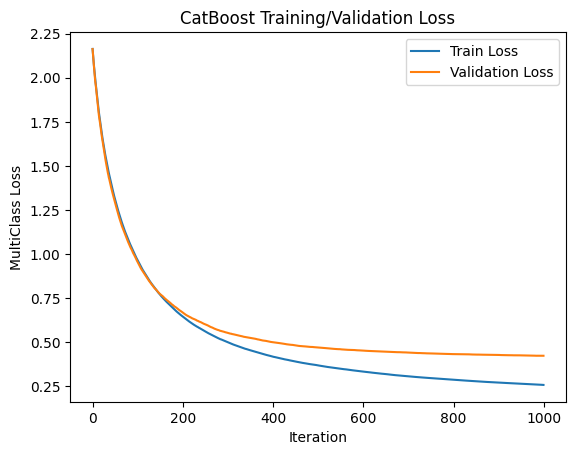

In [14]:
# Plot training and validation loss over iterations
plt.plot(evals_result["learn"]["MultiClass"], label="Train Loss")
plt.plot(evals_result["validation"]["MultiClass"], label="Validation Loss")
plt.xlabel("Iteration")
plt.ylabel("MultiClass Loss")
plt.legend()
plt.title("CatBoost Training/Validation Loss")
plt.show()

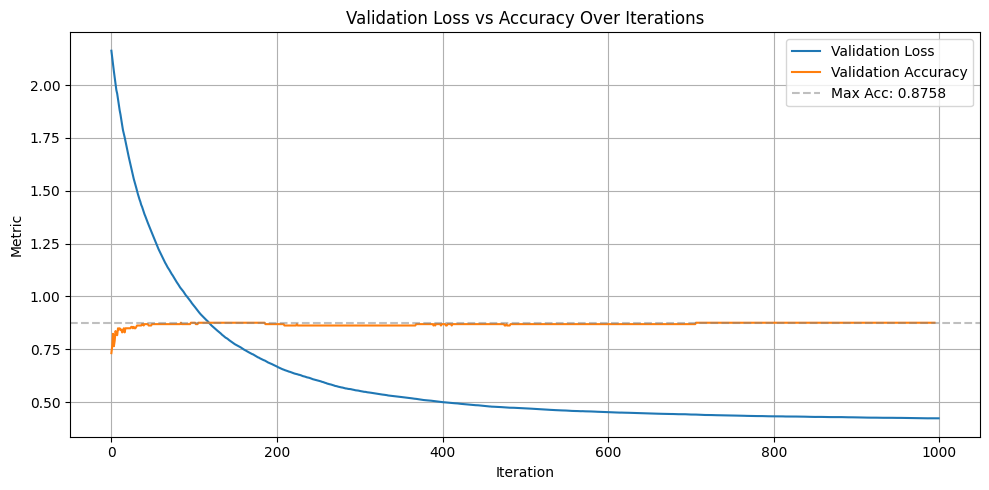

🎯 Max Validation Accuracy: 0.8758


In [15]:
# Manual accuracy tracking over trees
accuracies = []
for i in range(1, final_model.tree_count_ + 1):
    preds = final_model.predict(eval_pool, ntree_end=i)
    acc = (preds.flatten() == y_test_filtered.values).mean()
    accuracies.append(acc)

# Plot loss and accuracy
plt.figure(figsize=(10, 5))
plt.plot(evals_result["validation"]["MultiClass"], label="Validation Loss")
plt.plot(accuracies, label="Validation Accuracy")
plt.axhline(
    max(accuracies),
    color="gray",
    linestyle="--",
    alpha=0.5,
    label=f"Max Acc: {max(accuracies):.4f}",
)
plt.title("Validation Loss vs Accuracy Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Metric")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

max_acc = max(accuracies)
print(f"🎯 Max Validation Accuracy: {max_acc:.4f}")

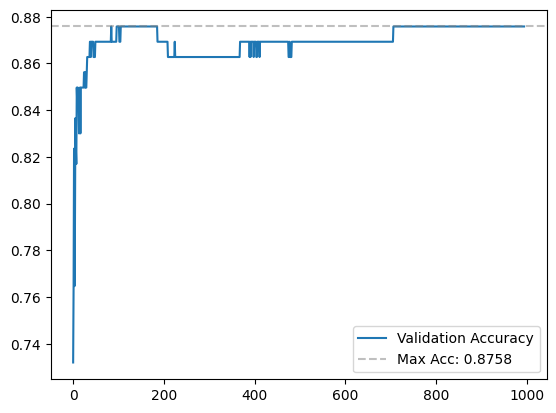

In [16]:
plt.plot(accuracies, label="Validation Accuracy")
plt.axhline(
    max_acc, color="gray", linestyle="--", alpha=0.5, label=f"Max Acc: {max_acc:.4f}"
)
plt.legend()
plt.show()

## 8. Model Evaluation and Prediction

* Predict on the test set using the trained model.
* Generate classification report (precision, recall, F1-score).
* Calculate overall accuracy.
* Generate confusion matrix
* Address class imbalance or missing predicted classes with zero\_division=0.

In [17]:
# Final prediction using full model
final_preds = final_model.predict(eval_pool).flatten()

# Evaluate class-wise performance
report = classification_report(y_test_filtered, final_preds, digits=4, zero_division=0)
print(report)

# Accuracy
acc = accuracy_score(y_test_filtered, final_preds)
print(f"Test Accuracy: {acc:.4f}")



              precision    recall  f1-score   support

         1.0     0.8857    0.9688    0.9254        64
         2.0     0.9615    0.8333    0.8929        30
         4.0     0.0000    0.0000    0.0000         5
         7.0     0.0000    0.0000    0.0000         2
         9.0     0.8545    0.9038    0.8785        52

    accuracy                         0.8758       153
   macro avg     0.5404    0.5412    0.5393       153
weighted avg     0.8495    0.8758    0.8607       153

Test Accuracy: 0.8758


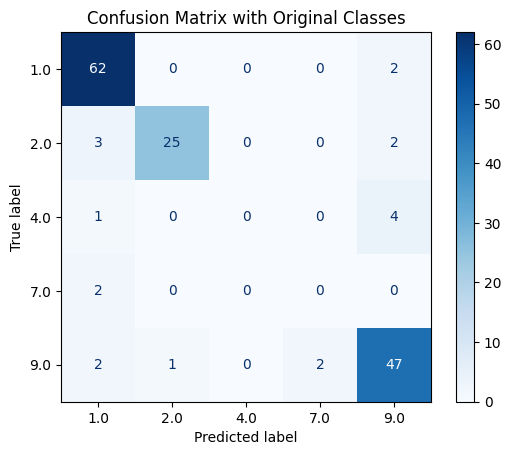

In [18]:
# Confusion Matrix

# Your original class labels sorted in the same order used internally by the classifier
class_names = sorted(y_test_filtered.unique())  # e.g. [1, 2, 4, 7, 9]

# Compute confusion matrix
cm = confusion_matrix(y_test_filtered, final_preds, labels=class_names)

# Plot with original class names as axis labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues")

plt.title("Confusion Matrix with Original Classes")
plt.show()


## 9. Cluster Coverage and Prediction Summary

* Analyze cluster distribution in full dataset, train and test splits, and model predictions.
* Calculate coverage percentages.
* Print summary statistics to contextualize model accuracy.



In [19]:
# Unique clusters in full dataset
full_clusters = set(Y.unique())

# Clusters in train and test
train_clusters = set(y_train.unique())
test_clusters = set(y_test.unique())

# Clusters predicted by model on test set
predicted_clusters = set(final_preds)

# Coverage calculations
coverage_test = (
    len(predicted_clusters.intersection(test_clusters)) / len(test_clusters) * 100
)
coverage_full = len(predicted_clusters) / len(full_clusters) * 100


# Class support counts
def cluster_support(y, label):
    counts = y.value_counts().sort_index()
    print(f"{label} cluster counts:")
    print(counts)
    print()


print(f"Total unique clusters in full data: {len(full_clusters)}")
cluster_support(Y, "Full dataset")
print(f"Clusters in training set: {len(train_clusters)}")
cluster_support(y_train, "Training set")
print(f"Clusters in test set: {len(test_clusters)}")
cluster_support(y_test, "Test set")
print(f"Clusters predicted by model: {len(predicted_clusters)}")
print(sorted(predicted_clusters))
print()

print(f"Cluster coverage of test set: {coverage_test:.2f}%")
print(f"Cluster coverage of full data: {coverage_full:.2f}%")
print(
    "\n⚠️ Note: Accuracy only reflects predictions on covered clusters; unseen clusters will have no reliable predictions."
)

Total unique clusters in full data: 10
Full dataset cluster counts:
Cluster_ID_Next
0.0     97
1.0    426
2.0    139
3.0    182
4.0     76
5.0     34
6.0    120
7.0    312
8.0    201
9.0    283
Name: count, dtype: int64

Clusters in training set: 9
Training set cluster counts:
Cluster_ID_Next
0.0     97
1.0    362
2.0    109
3.0    182
4.0     71
6.0    120
7.0    310
8.0    201
9.0    231
Name: count, dtype: int64

Clusters in test set: 6
Test set cluster counts:
Cluster_ID_Next
1.0    64
2.0    30
4.0     5
5.0    34
7.0     2
9.0    52
Name: count, dtype: int64

Clusters predicted by model: 4
[np.float64(1.0), np.float64(2.0), np.float64(7.0), np.float64(9.0)]

Cluster coverage of test set: 66.67%
Cluster coverage of full data: 40.00%

⚠️ Note: Accuracy only reflects predictions on covered clusters; unseen clusters will have no reliable predictions.


In [20]:
cluster_counts = df["Cluster_ID"].value_counts().sort_index()
cluster_distribution_df = cluster_counts.reset_index()
cluster_distribution_df.columns = ["Cluster_ID", "Count"]
cluster_distribution_df

,Cluster_ID,Count
0,0.0,97
1,1.0,426
2,2.0,139
3,3.0,182
4,4.0,76
5,5.0,34
6,6.0,122
7,7.0,312
8,8.0,203
9,9.0,283


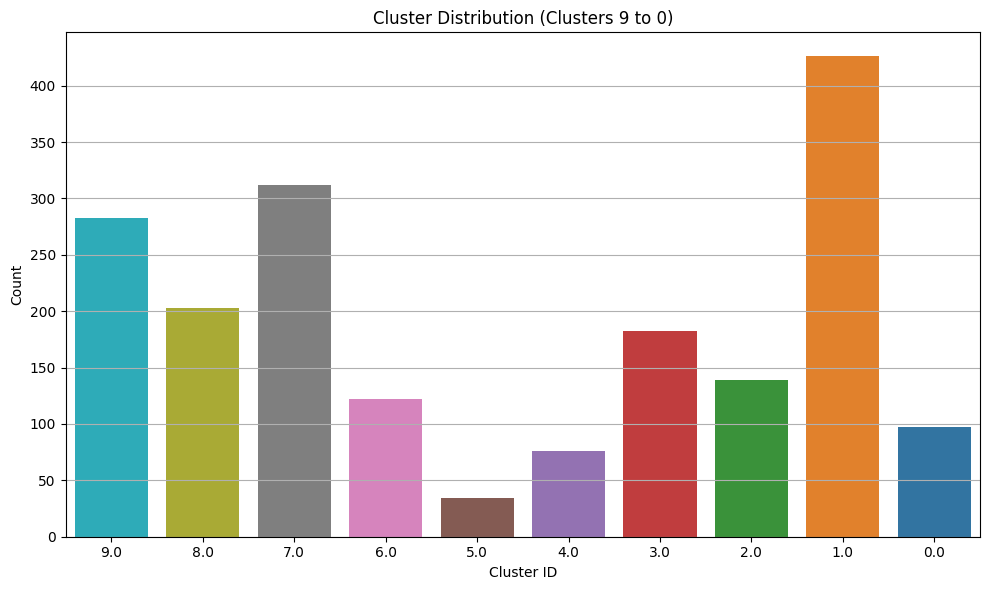

In [21]:
# Sort DataFrame by Cluster_ID descending (from 9 down to 0)
cluster_distribution_df_desc = cluster_distribution_df.sort_values(
    "Cluster_ID", ascending=False
)

plt.figure(figsize=(10, 6))
sns.barplot(
    x="Cluster_ID",
    y="Count",
    data=cluster_distribution_df_desc,
    order=cluster_distribution_df_desc["Cluster_ID"],
    palette="tab10",
    dodge=False,
    hue="Cluster_ID",
    legend=False,
)
plt.title("Cluster Distribution (Clusters 9 to 0)")
plt.xlabel("Cluster ID")
plt.ylabel("Count")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

In [22]:
print("Cluster 7 count in train:", (y_train == 7).sum())
print("Cluster 7 count in test:", (y_test == 7).sum())

Cluster 7 count in train: 310
Cluster 7 count in test: 2


## 10. SHAP Feature Importance & Interpretation

- Explain model predictions using SHAP values.

- Visualize feature impact on predicted regime transitions.

- Identify which features most influence model decisions.

- Support deeper insight into regime drivers and potential drift indicators.


In [23]:
# Unique classes present in filtered test labels
unique_test_classes = sorted(y_test_filtered.unique())
print("Classes in filtered test set:", unique_test_classes)

# Unique classes predicted by the model on filtered test set
unique_pred_classes = sorted(np.unique(final_preds))
print("Classes predicted by the model:", unique_pred_classes)

Classes in filtered test set: [np.float64(1.0), np.float64(2.0), np.float64(4.0), np.float64(7.0), np.float64(9.0)]
Classes predicted by the model: [np.float64(1.0), np.float64(2.0), np.float64(7.0), np.float64(9.0)]


In [24]:
feature_names = preprocessor.get_feature_names_out()
print(len(feature_names))  # Should be 47
print(feature_names)       # Matches what you pasted


47
['num_pipeline__Cluster_ID_Lag_1' 'num_pipeline__Cluster_ID_Lag_2'
 'num_pipeline__Cluster_ID_Lag_3' 'num_pipeline__Confidence'
 'num_pipeline__ATR' 'num_pipeline__AHMA'
 'num_pipeline__Leavitt_Projection' 'num_pipeline__Leavitt_Convolution'
 'num_pipeline__LC_Slope' 'num_pipeline__LC_Intercept'
 'num_pipeline__LC_Acceleration' 'num_pipeline__Convolution_Probability'
 'num_pipeline__Baseline_Bullish' 'num_pipeline__Baseline_Bearish'
 'num_pipeline__Baseline_Valid' 'num_pipeline__ML_Confirmed'
 'num_pipeline__LC_Acceleration_Shift' 'num_pipeline__LC_Slope_Shift'
 'num_pipeline__LC_Acceleration_STD' 'num_pipeline__LC_Slope_STD'
 'num_pipeline__Threshold' 'num_pipeline__Confirm_Threshold'
 'num_pipeline__Trend' 'num_pipeline__Trend_Within_Threshold'
 'num_pipeline__Confirmed_Trend'
 'num_pipeline__Confirmed_Trend_Within_Threshold'
 'num_pipeline__News_Conflict' 'num_pipeline__LC_Prev'
 'num_pipeline__LP_Prev' 'num_pipeline__LP_Slope'
 'num_pipeline__Trend_Bull' 'num_pipeline__Trend_Bea

In [25]:
# Use CatBoost’s TreeExplainer (fast and compatible)
explainer = shap.TreeExplainer(final_model)

In [26]:
print(X_test_transformed.shape)

shap_values = explainer.shap_values(X_test_transformed_filtered)

(187, 47)


In [27]:
# Confirm SHAP values shape matches input shape
print(f"SHAP values shape: {np.array(shap_values).shape}")
print(f"X_test_transformed_filtered shape: {X_test_transformed_filtered.shape}")

SHAP values shape: (153, 47, 9)
X_test_transformed_filtered shape: (153, 47)


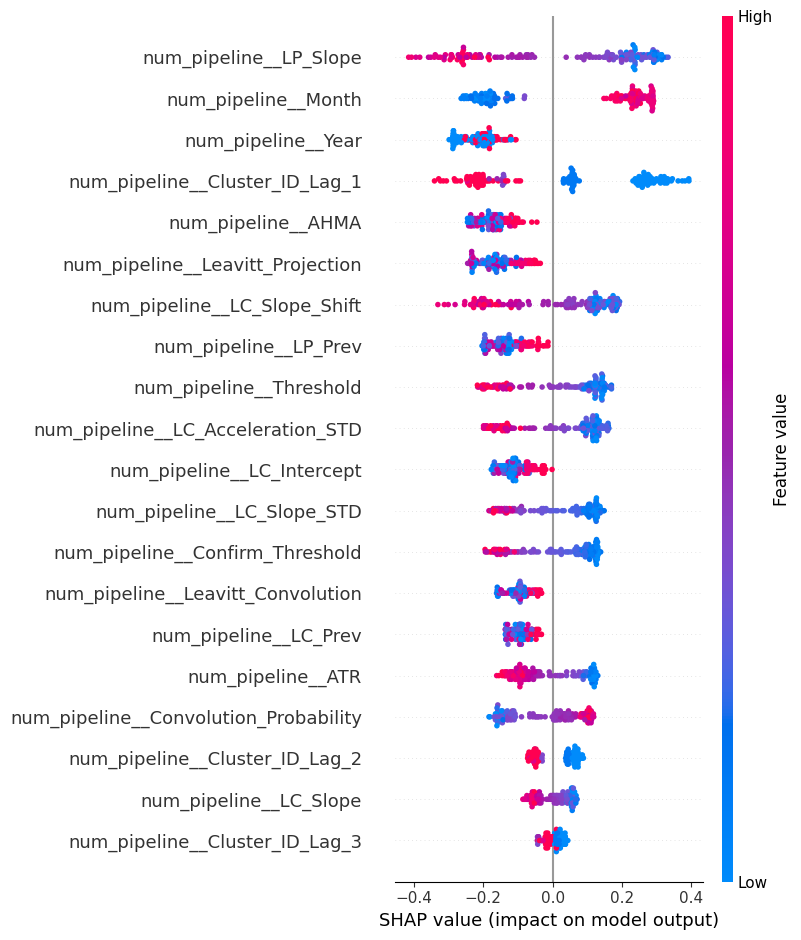

In [28]:
# For multi-class, shap_values is a list or array of shape (num_classes, num_samples, num_features)
# Select SHAP values for one class (e.g., class 0) or average as needed
shap_class_0 = shap_values[:, :, 0]  

# Plot summary plot for class 0
shap.summary_plot(
    shap_class_0, X_test_transformed_filtered, feature_names=feature_names
)

Class index to label mapping:
Class 0: 0.0
Class 1: 1.0
Class 2: 2.0
Class 3: 3.0
Class 4: 4.0
Class 5: 6.0
Class 6: 7.0
Class 7: 8.0
Class 8: 9.0


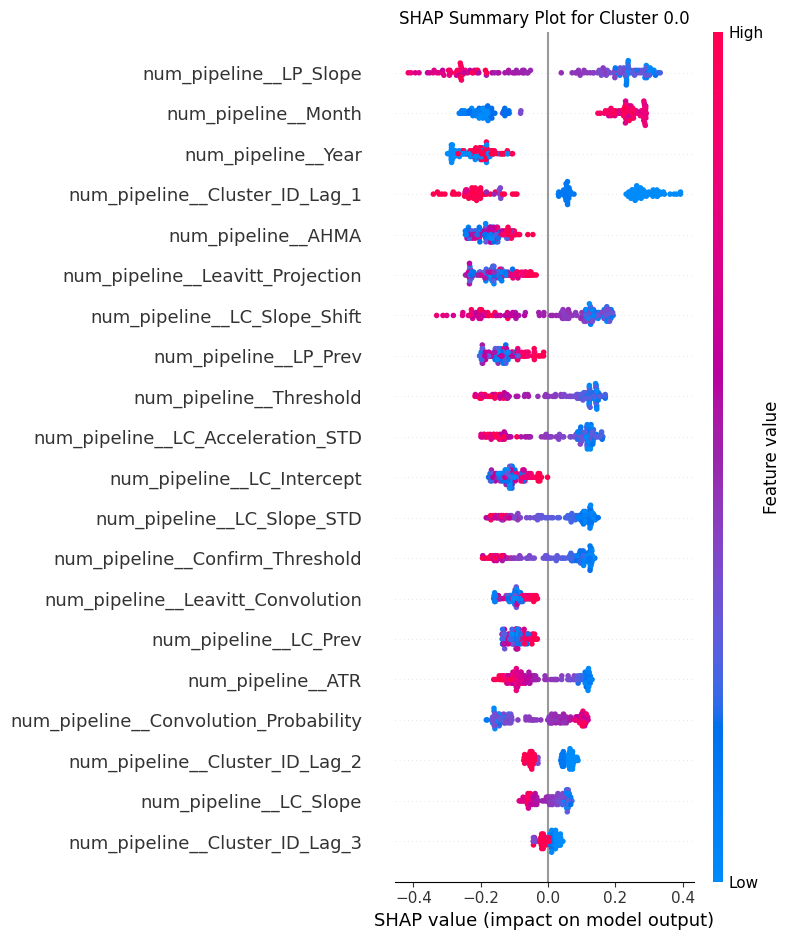

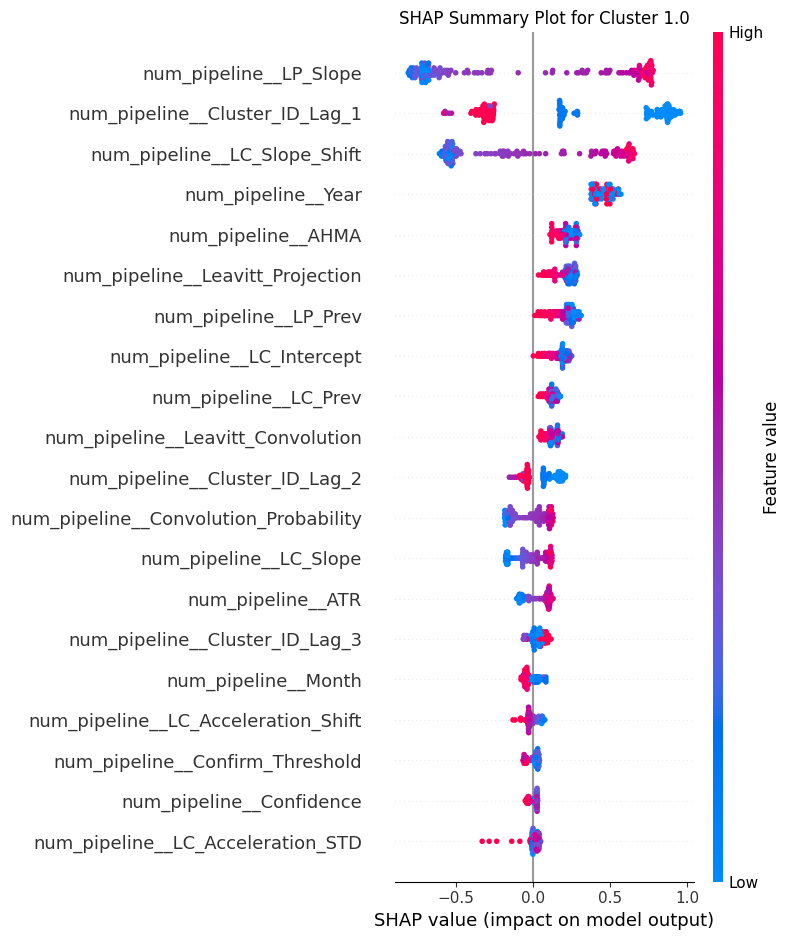

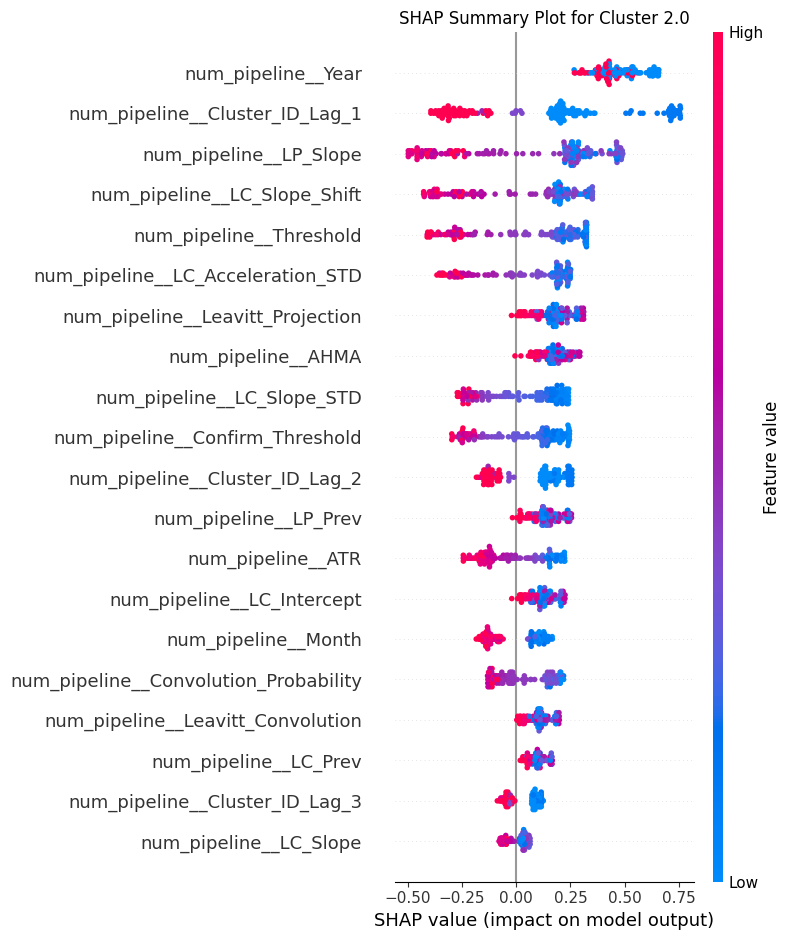

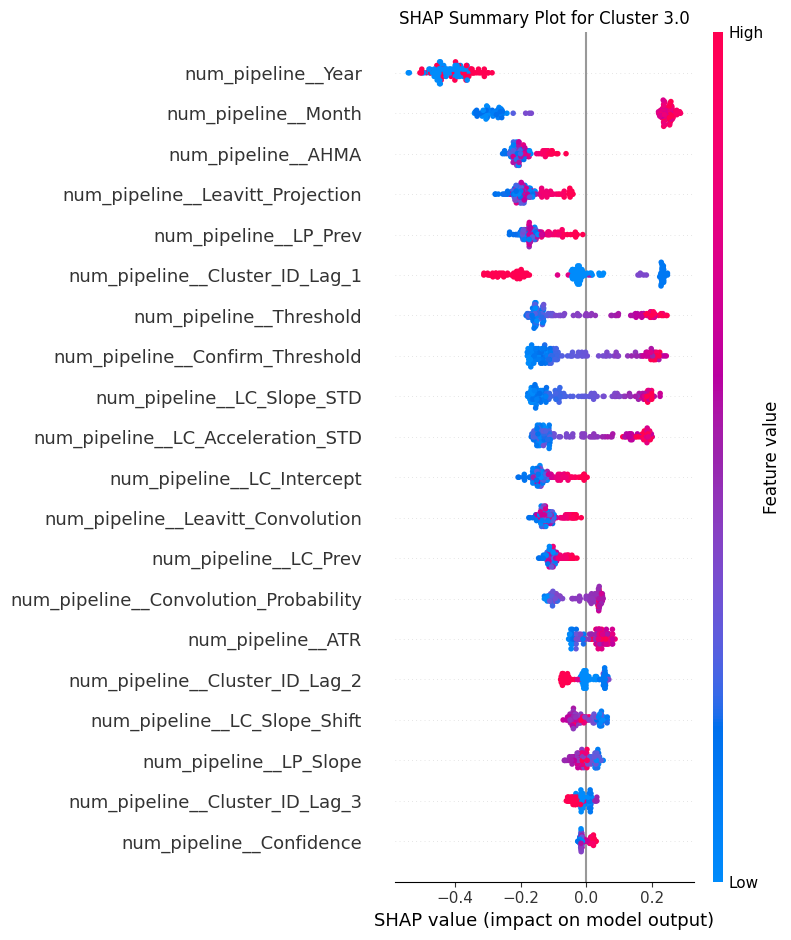

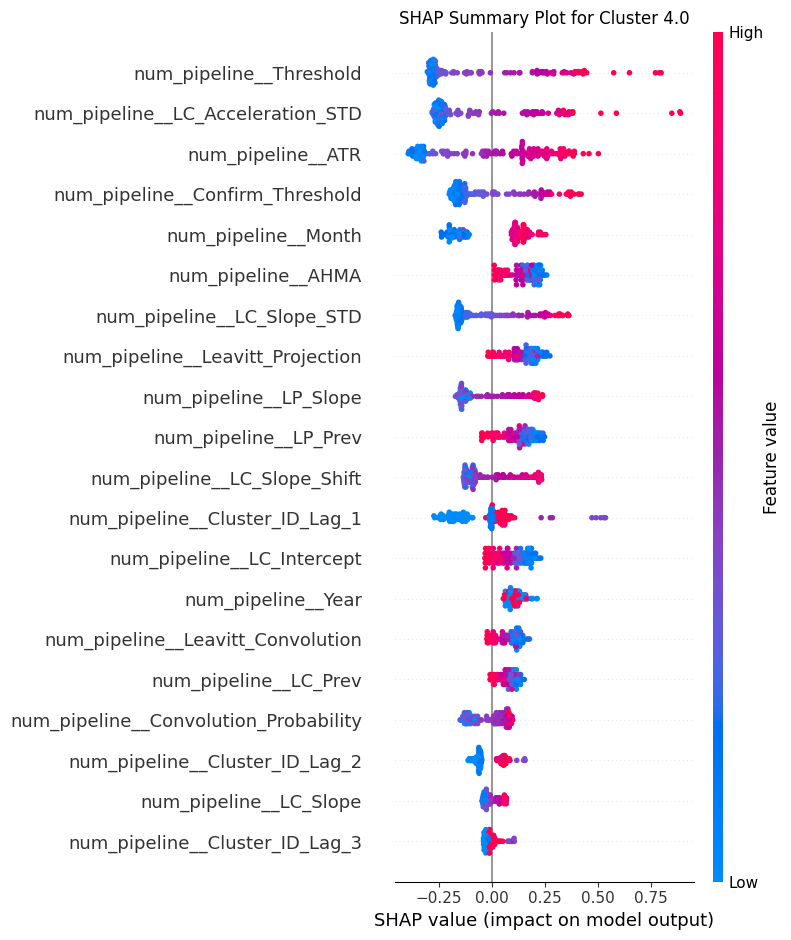

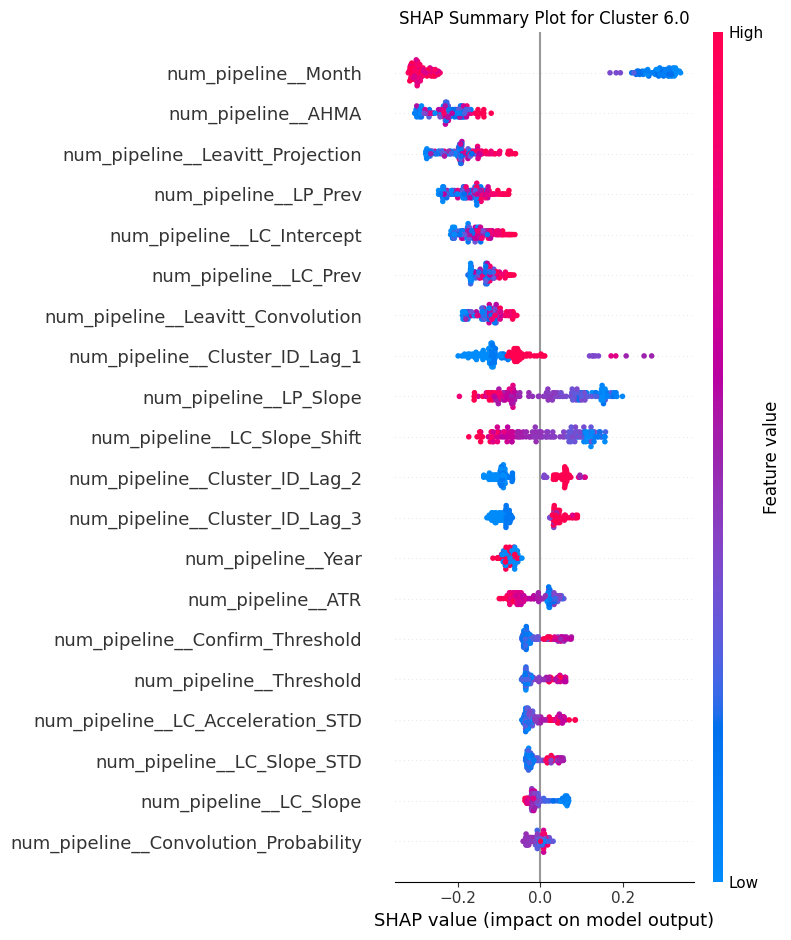

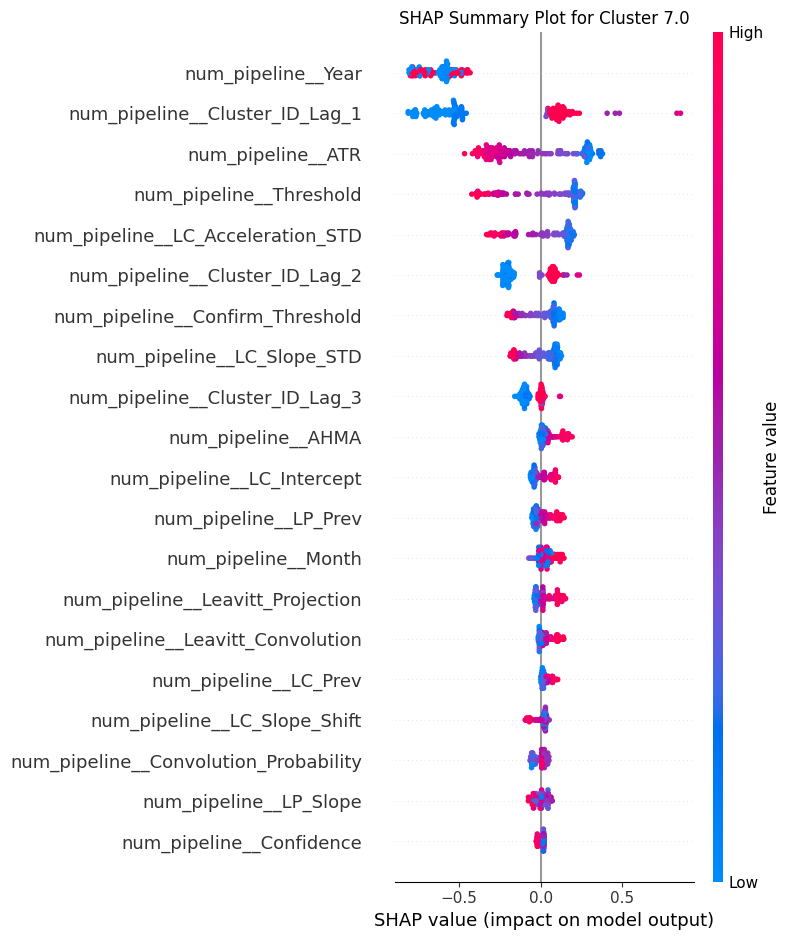

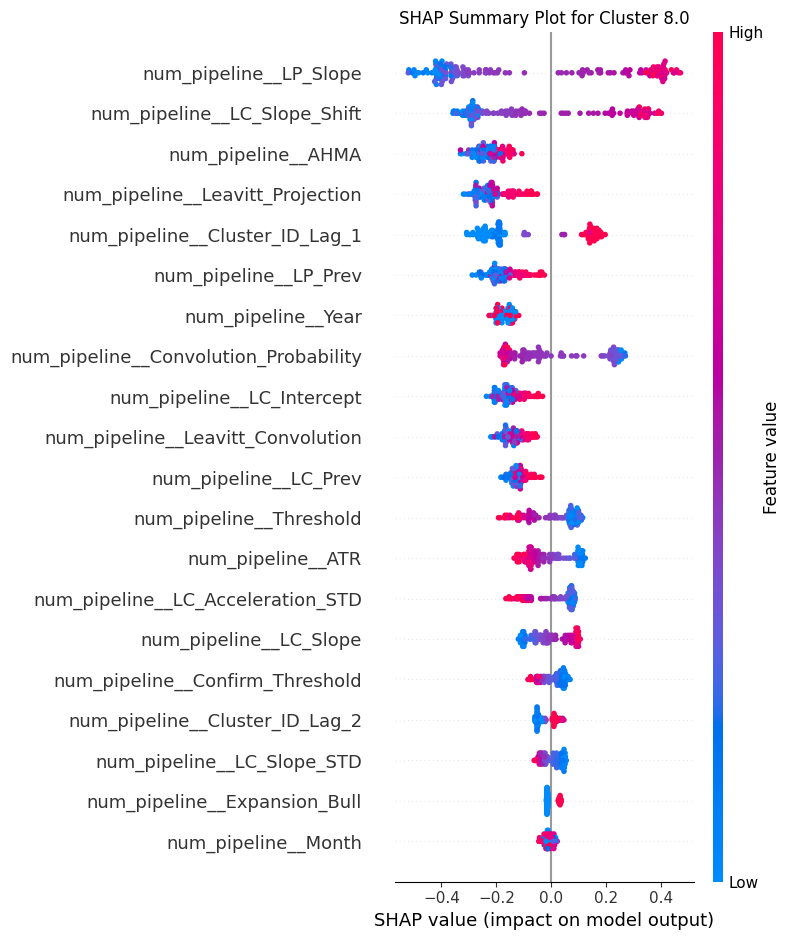

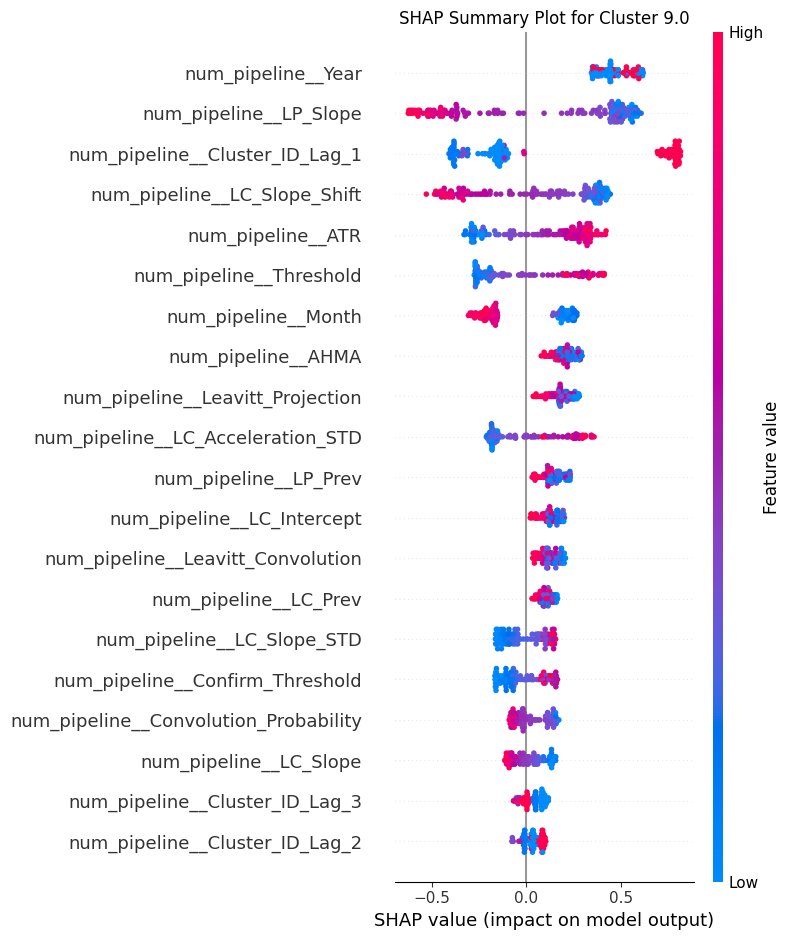

In [31]:
# Recreate class mapping
original_classes = sorted(np.unique(y_train))  # or y_train_filtered if applied
class_index_to_label = {i: label for i, label in enumerate(original_classes)}
print("Class index to label mapping:")
for idx, label in class_index_to_label.items():
    print(f"Class {idx}: {label}")
# Use this mapping when plotting
for class_idx in range(shap_values.shape[2]):
    class_label = class_index_to_label[class_idx]
    shap_class_values = shap_values[:, :, class_idx]
    shap.summary_plot(
        shap_class_values,
        X_test_transformed_filtered,
        feature_names=feature_names,
        show=False,
    )
    plt.title(f"SHAP Summary Plot for Cluster {class_label}")
    plt.tight_layout()
    plt.show()